In [65]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np

from numpy.random import default_rng
RANDOM_STATE = 2 # random state for default_rng
rng = default_rng(RANDOM_STATE)


import random
#import memory_profiler
import altair as alt
from tqdm import tqdm
import datetime

# CHECKLIST for Kaggle variant
# USE_ALL_STOCK_IDS False to check then True
# USE_TEST_LOCAL_6_ITEMS must be False else we override the locl test data
# TEST_SIZE must be 0 to get all items
# Check on Kaggle that "internet" is disabled

t1_notebook_start = datetime.datetime.utcnow()

if os.environ.get('USER') == 'ian':
    ENV_HOME = True
    import ipython_memory_usage
    %ipython_memory_usage_start
    USE_ALL_STOCK_IDS = True
    NBR_FOR_SUBSET_OF_STOCK_IDS = 4
    TEST_SIZE = 0.25
    USE_TEST_LOCAL_6_ITEMS = True # robust local testing at home
    #USE_TEST_LOCAL_6_ITEMS = False # robust local testing at home TEMPORARY WHILST DEBUGGING
else:
    ENV_HOME = False
    USE_ALL_STOCK_IDS = False # for KAGGLE on first-upload for a quick test
    TEST_SIZE = 0
    USE_TEST_LOCAL_6_ITEMS = False
    # kaggle notes:
    # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
    # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


if USE_ALL_STOCK_IDS:
    NBR_FOR_SUBSET_OF_STOCK_IDS=None
print(f'ENV_HOME: {ENV_HOME}, TEST_SIZE {TEST_SIZE}, USE_ALL_STOCK_IDS {USE_ALL_STOCK_IDS}, USE_TEST_LOCAL_6_ITEMS {USE_TEST_LOCAL_6_ITEMS}')
print(f'NBR_FOR_SUBSET_OF_STOCK_IDS: {NBR_FOR_SUBSET_OF_STOCK_IDS}')

ENV_HOME: True, TEST_SIZE 0.25, USE_ALL_STOCK_IDS True, USE_TEST_LOCAL_6_ITEMS True
NBR_FOR_SUBSET_OF_STOCK_IDS: None
In [65] used 0.4375 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 6310.03 MiB


In [2]:
# OR PASTE IN UTILITY CODE HERE FOR KAGGLE
from utility import make_unique_time_ids, get_training_stock_ids
from utility import ROOT, TEST_CSV, TRAIN_CSV

Utility says ROOT is /home/ian/data/kaggle/optiver_volatility/
In [2] used 0.0000 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 134.04 MiB


## Load train set

In [3]:
stock_ids = get_training_stock_ids('book_train.parquet') # all stocks by default

if not USE_ALL_STOCK_IDS:
    # choose a random subset
    print(f"Using a subset of {NBR_FOR_SUBSET_OF_STOCK_IDS}")
    rng.shuffle(stock_ids)
    #random.shuffle(stock_ids)
    stock_ids = stock_ids[:NBR_FOR_SUBSET_OF_STOCK_IDS]
else:
    print("Using all")
stock_ids[:3] # expect 59, 58, 23 if we're using all or 76, 73, 0 on the RANDOM_STATE of 1 if we don't use all stock ids

Using all


[59, 58, 23]

In [3] used 0.4141 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 134.45 MiB


In [4]:
df_train_all = pd.read_csv(TRAIN_CSV)
df_train_all = df_train_all.set_index(['stock_id', 'time_id'])
print(df_train_all.shape)
#rows_for_stock_id_0 = df_train_all.query('stock_id == 0').shape[0]
#rows_for_stock_id_0

(428932, 1)
In [4] used 22.4961 MiB RAM in 0.28s, peaked 5.48 MiB above current, total RAM usage 156.95 MiB


In [5]:
def show_details(df):
    try:
        nbr_index_levels = len(df.index.levels)
    except AttributeError:
        nbr_index_levels = 1
    nbr_nulls = df.isnull().sum().sum()
    #nulls_msg = "Has no nulls"
    #if nbr_nulls==0:
    nulls_msg = f"{nbr_nulls} nulls"
    is_view_msg = f'is_view {df_train_all._data.is_view}'
    is_single_block_msg = f'is_single_block {df_train_all._data.is_single_block}'
    is_consolidated_msg = f'is_consolidated {df_train_all._data.is_consolidated()}'    
    print(f'[{nbr_index_levels}c] {df.shape[0]:,}x{df.shape[1]:,}, {nulls_msg}, {is_view_msg}, {is_single_block_msg}, {is_consolidated_msg}')

show_details(df_train_all)

[2c] 428,932x1, 0 nulls, is_view True, is_single_block True, is_consolidated True
In [5] used 0.0039 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 156.95 MiB


In [6]:
all_time_ids = df_train_all.reset_index().time_id.unique()
#np.random.shuffle(all_time_ids) # shuffle the time_ids
rng.shuffle(all_time_ids)
print(f"We have {len(all_time_ids):,} time ids")
time_ids_train, time_ids_test = make_unique_time_ids(all_time_ids, test_size=TEST_SIZE)
assert len(time_ids_train) + len(time_ids_test) == len(all_time_ids)
assert len(time_ids_train.intersection(time_ids_test)) == 0, "Expecting no overlap between train and test time ids"
print(f"Example time ids for training, min first: {sorted(list(time_ids_train))[:5]}")

We have 3,830 time ids
Taking 2,872 for train and 958 for test
Example time ids for training, min first: [5, 11, 16, 31, 62]
In [6] used -6.3281 MiB RAM in 0.14s, peaked 6.33 MiB above current, total RAM usage 150.62 MiB


In [7]:
# make feature columns
def make_features_stats(df_book, agg_type, cols):
    features_var1 = df_book.groupby(['stock_id', 'time_id'])[cols].agg(agg_type)
    if isinstance(features_var1, pd.Series):
        # .size yields a series not a df
        #features_var1.name = str(agg_type)
        features_var1 = pd.DataFrame(features_var1, columns=[agg_type])
    else:
        features_var1_col_names = [f"{col}_{agg_type}" for col in cols]
        features_var1.columns = features_var1_col_names
    return features_var1

In [7] used 0.0000 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 150.62 MiB


In [8]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

In [8] used 0.0195 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 150.64 MiB


In [66]:
def realized_volatility_weighted(series_log_return, weights=None):
    """Weighted volatility"""
    ser = series_log_return
    if weights is None:
        weights = np.ones(ser.shape[0])
    elif weights == 'linear':
        weights = np.linspace(0.1, 1, series_log_return.shape[0]) # linear increasing weight
    ser_weighted = ser * weights
    return np.sqrt(np.sum(ser_weighted**2))

if False:
    # example usage
    series_log_return = np.linspace(0, 10, 6)
    weights = np.linspace(0.1, 1, series_log_return.shape[0]) # linear increasing weight

    half_way = int(series_log_return.shape[0] / 2)
    weights = np.concatenate((np.zeros(half_way), np.ones(series_log_return.shape[0] - half_way))) # 0s then 1s weight

    weights = np.ones(series_log_return.shape[0]) # use all items equally
    assert weights.shape[0] == series_log_return.shape[0]
    realized_volatility_weighted(series_log_return, weights)

In [66] used 0.0000 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 6310.03 MiB


In [67]:
def make_wap(df_book_data, num=1):
    """Modifies df_book_data"""
    assert num==1 or num==2
    wap_numerator = (df_book_data[f'bid_price{num}'] * df_book_data[f'ask_size{num}'] +
                                     df_book_data[f'ask_price{num}'] * df_book_data[f'bid_size{num}'])
    wap_denominator = df_book_data[f'bid_size{num}'] + df_book_data[f'ask_size{num}']
    df_book_data['wap'] = wap_numerator / wap_denominator

def make_realized_volatility(df_book_data, log_return_name='log_return', weights=None):
    df_book_data[log_return_name] = df_book_data.groupby(['stock_id', 'time_id'])['wap'].apply(log_return)
    df_book_data = df_book_data[~df_book_data[log_return_name].isnull()]
    df_realized_vol_per_stock =  pd.DataFrame(df_book_data.groupby(['stock_id', 'time_id'])[log_return_name].agg(realized_volatility_weighted, weights))
    return df_realized_vol_per_stock

In [67] used 0.0000 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 6310.03 MiB


In [68]:
if True: # lightweight tests
    df_book_train_stock_XX = pd.read_parquet(os.path.join(ROOT, f"book_train.parquet/stock_id=0"))
    df_book_train_stock_XX["stock_id"] = 0
    df_book_train_stock_XX = df_book_train_stock_XX.set_index(['stock_id', 'time_id'])
    make_wap(df_book_train_stock_XX, 2) # adds 'wap' column
    df_realized_vol_per_stockXX = make_realized_volatility(df_book_train_stock_XX, log_return_name="log_return2", weights='linear')
    display(df_realized_vol_per_stockXX)

log_return2
stock_id time_id             
0        5           0.004500
         11          0.001749
         16          0.003284
         31          0.002465
         62          0.001806
...                       ...
         32751       0.002343
         32753       0.001905
         32758       0.002118
         32763       0.003160
         32767       0.001316

[3830 rows x 1 columns]

In [68] used 29.1602 MiB RAM in 3.65s, peaked 73.44 MiB above current, total RAM usage 6339.19 MiB


In [42]:
def load_data_build_features(stock_id, ROOT, filename, cols, df_target):
    # filename e.g. book_train.parquet
    assert isinstance(stock_id, int)
    df_book_train_stock_X = pd.read_parquet(
        os.path.join(ROOT, f"{filename}/stock_id={stock_id}")
    )
    df_book_train_stock_X["stock_id"] = stock_id
    df_book_train_stock_X = df_book_train_stock_X.set_index(['stock_id', 'time_id'])
    #assert df_book_train_stock_X.shape[0] > rows_for_stock_id_0, (df_book_train_stock_X.shape[0], rows_for_stock_id_0)
    
    #df_book_train_stock_X_gt500 = df_book_train_stock_X.query("seconds_in_bucket>500").copy()
    #df_realized_vol_per_stock_short500 = add_wap_make_realized_volatility(df_book_train_stock_X_gt500, log_return_name='log_return_gt500sec')
    #df_book_train_stock_X_gt300 = df_book_train_stock_X.query("seconds_in_bucket>300").copy()
    #df_realized_vol_per_stock_short300 = add_wap_make_realized_volatility(df_book_train_stock_X_gt300, log_return_name='log_return_gt300sec')
    make_wap(df_book_train_stock_X, 2) # adds 'wap' column
    df_realized_vol_per_stock_num2 = make_realized_volatility(df_book_train_stock_X, log_return_name="log_return2")    
    make_wap(df_book_train_stock_X, 1) # adds 'wap' column
    df_realized_vol_per_stock_num1 = make_realized_volatility(df_book_train_stock_X, log_return_name="log_return1")
    df_realized_vol_per_stock_num1_linear_weight = make_realized_volatility(df_book_train_stock_X, log_return_name="log_return1_linear_weight", weights='linear')
    features_var1 = make_features_stats(df_book_train_stock_X, 'var', cols)
    #print(f"{features_var1.memory_usage().sum() / 1_000_000:0.1f} MB")
    features_mean1 = make_features_stats(df_book_train_stock_X, 'mean', cols)
    features_size1 = make_features_stats(df_book_train_stock_X, 'size', cols)
    
    df_train_stock_X = df_target.query('stock_id == @stock_id')
    to_merge = [df_train_stock_X, features_var1, features_mean1, features_size1, 
                df_realized_vol_per_stock_num1, df_realized_vol_per_stock_num2, df_realized_vol_per_stock_num1_linear_weight]
                #df_realized_vol_per_stock_short300, df_realized_vol_per_stock_short500, ]
    row_lengths = [df.shape[0] for df in to_merge]
    assert len(set(row_lengths)) == 1, row_lengths # should all be same length
    train_merged = pd.concat(to_merge, axis=1)
    return train_merged

print(f'Iterating over {len(stock_ids)} stocks:')
    
cols = ['bid_price1', 'ask_price1', 'bid_price2', 'ask_price2',] 
cols += ['bid_size1', 'ask_size1', 'bid_size2', 'ask_size2']
#cols += ['wap', 'wap_numerator', 'wap_denominator']

if True:    
    # test...
    train_mergedXX = load_data_build_features(0, ROOT, 'book_train.parquet', cols, df_train_all)
    display(train_mergedXX)

Iterating over 112 stocks:


/tmp/ipykernel_721316/1151768668.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if weights == 'linear':


target  bid_price1_var  ask_price1_var  bid_price2_var  \
stock_id time_id                                                             
0        5        0.004136    3.557702e-07    3.609267e-07    3.278967e-07   
         11       0.001445    8.048454e-08    4.782809e-08    5.987733e-08   
         16       0.002168    5.057495e-07    6.204843e-07    5.307066e-07   
         31       0.002195    4.746649e-07    3.223060e-07    5.349445e-07   
         62       0.001747    4.740689e-08    3.653909e-08    5.247379e-08   
...                    ...             ...             ...             ...   
         32751    0.002611    3.989057e-07    5.059281e-07    3.846314e-07   
         32753    0.001190    1.837252e-07    2.433933e-07    2.033434e-07   
         32758    0.004264    5.668076e-07    4.536424e-07    6.043470e-07   
         32763    0.004352    1.058614e-07    1.051107e-07    1.070506e-07   
         32767    0.001084    5.710588e-07    5.752923e-07    6.009845e-07   

                  ask_price2_var  bid_size1_var  ask_size1_var  bid_size2_var  \
stock_id time_id                                                                
0        5          3.649655e-07    6592.215309    4338.669743    7348.756507   
         11         4.715270e-08   15492.325402    9691.320578    8465.001985   
         16         6.152997e-07    4978.115912    9259.747269    5674.860251   
         31         3.222207e-07    8093.880602   10996.043697    5778.103922   
         62         3.838027e-08    9499.414513    9603.210909    7059.243117   
...                          ...            ...            ...            ...   
         32751      4.818288e-07    9490.991605   10394.996610    4828.041246   
         32753      2.618266e-07   28270.493701   20407.077646   15863.063249   
         32758      4.448702e-07    6587.428917    7851.263511    2219.748436   
         32763      1.431541e-07    7244.247983    6607.922889    8062.183603   
         32767      5.970896e-07    9402.179206   10214.490359   12848.133608   

                  ask_size2_var  bid_price1_mean  ...  bid_price2_mean  \
stock_id time_id                                  ...                    
0        5          5184.163572         1.003314  ...         1.003139   
         11         7875.531633         1.000011  ...         0.999870   
         16         4586.227415         0.999204  ...         0.999007   
         31         6483.167437         0.998445  ...         0.998255   
         62         4527.422208         0.999407  ...         0.999216   
...                         ...              ...  ...              ...   
         32751      9333.874374         0.997639  ...         0.997556   
         32753     10575.195643         1.000141  ...         1.000049   
         32758      5428.886648         0.999334  ...         0.999131   
         32763      5552.617083         1.002087  ...         1.001974   
         32767      6756.769515         0.998886  ...         0.998762   

                  ask_price2_mean  bid_size1_mean  ask_size1_mean  \
stock_id time_id                                                    
0        5               1.004320       78.264901       74.579470   
         11              1.000541      149.965000       71.145000   
         16              1.000127       96.132979      131.037234   
         31              0.999413      114.458333      120.800000   
         62              0.999913      119.823864       88.477273   
...                           ...             ...             ...   
         32751           0.998372      110.929293       87.632997   
         32753           1.000856      113.325243      228.140777   
         32758           0.999941       77.175532      100.904255   
         32763           1.002734      113.019544       83.853420   
         32767           0.999471      155.267544      137.372807   

                  bid_size2_mean  ask_size2_mean  size  log_return1  \
stock_id time_id   

In [42] used 2.2578 MiB RAM in 10.75s, peaked 163.29 MiB above current, total RAM usage 3462.87 MiB


In [43]:
from joblib import Parallel, delayed
all_train_merged = Parallel(n_jobs=-1, verbose=2)(delayed(load_data_build_features)(stock_id, ROOT, 'book_train.parquet', cols, df_train_all) for stock_id in stock_ids)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min


In [43] used 75.2188 MiB RAM in 321.75s, peaked 0.00 MiB above current, total RAM usage 3538.09 MiB


[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  5.4min finished


In [44]:
# join all the partial results back together
train_merged = pd.concat(all_train_merged)
show_details(train_merged)

[2c] 428,932x21, 0 nulls, is_view True, is_single_block True, is_consolidated True
In [44] used -36.0000 MiB RAM in 0.21s, peaked 36.00 MiB above current, total RAM usage 3502.09 MiB


In [45]:
train_merged.head()

target  bid_price1_var  ask_price1_var  bid_price2_var  \
stock_id time_id                                                             
59       5        0.004072    1.539389e-07    1.544176e-07    1.349132e-07   
         11       0.001489    3.412355e-07    4.039657e-07    3.298110e-07   
         16       0.002563    5.515992e-07    5.405377e-07    5.369475e-07   
         31       0.002323    4.119776e-08    9.782350e-08    5.722407e-08   
         62       0.002398    2.799989e-07    3.039634e-07    2.906845e-07   

                  ask_price2_var  bid_size1_var  ask_size1_var  bid_size2_var  \
stock_id time_id                                                                
59       5          1.465483e-07   11855.387055    6892.936853    4510.521751   
         11         4.177058e-07   22438.854139   32757.977261   35927.916710   
         16         5.369036e-07   10481.927458   12315.572839    6729.414078   
         31         9.959539e-08    6566.613651    7043.215464    5424.648518   
         62         2.920635e-07   16026.168376   12337.165290    9310.249809   

                  ask_size2_var  bid_price1_mean  ...  bid_price2_mean  \
stock_id time_id                                  ...                    
59       5          5765.414169         1.000904  ...         1.000779   
         11        16786.511136         1.000577  ...         1.000439   
         16         6091.421681         0.999024  ...         0.998933   
         31         8061.372315         1.000029  ...         0.999890   
         62         7555.724324         0.997103  ...         0.996995   

                  ask_price2_mean  bid_size1_mean  ask_size1_mean  \
stock_id time_id                                                    
59       5               1.001524      127.993569      111.192926   
         11              1.001341      141.639594      199.111675   
         16              0.999480      150.673077      168.711538   
         31              1.000685      104.837500       85.754167   
         62              0.997660      117.227642      164.504065   

                  bid_size2_mean  ask_size2_mean  size  log_return1  \
stock_id time_id                                                      
59       5            107.504823       75.237942   311     0.002861   
         11           170.040609      127.426396   197     0.002905   
         16           123.246154       93.738462   260     0.002423   
         31            85.004167      114.341667   240     0.002573   
         62           124.056911      102.101626   246     0.002345   

                  log_return2  log_return1_linear_weight  
stock_id time_id                                          
59       5           0.003991                   0.001431  
         11          0.004020                   0.001629  
         16          0.003329                   0.001488  
         31          0.003381                   0.001407  
         62          0.003060                   0.001263  

[5 rows x 21 columns]

In [45] used 0.0078 MiB RAM in 0.14s, peaked 0.00 MiB above current, total RAM usage 3502.09 MiB


In [46]:
features = train_merged.drop(columns='target').columns
features

Index(['bid_price1_var', 'ask_price1_var', 'bid_price2_var', 'ask_price2_var',
       'bid_size1_var', 'ask_size1_var', 'bid_size2_var', 'ask_size2_var',
       'bid_price1_mean', 'ask_price1_mean', 'bid_price2_mean',
       'ask_price2_mean', 'bid_size1_mean', 'ask_size1_mean', 'bid_size2_mean',
       'ask_size2_mean', 'size', 'log_return1', 'log_return2',
       'log_return1_linear_weight'],
      dtype='object')

In [46] used 39.2734 MiB RAM in 0.17s, peaked 0.00 MiB above current, total RAM usage 3541.37 MiB


# Features

In [47]:
def train_test_split(df, target_col, time_ids_train, time_ids_test):
    X_train = df.query('time_id in @time_ids_train').drop(columns=[target_col, 'time_id'])
    X_test = df.query('time_id in @time_ids_test').drop(columns=[target_col, 'time_id'])
    y_train = df.query('time_id in @time_ids_train')[target_col]
    y_test = df.query('time_id in @time_ids_test')[target_col]
    return X_train, X_test, y_train, y_test

feature_cols = list(features) + ['stock_id']
X_train, X_test, y_train, y_test = train_test_split(train_merged.reset_index()[feature_cols+['time_id', 'target']], 'target', time_ids_train, time_ids_test)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((321646, 21), (107286, 21), (321646,), (107286,))

In [47] used 128.3047 MiB RAM in 0.31s, peaked 9.75 MiB above current, total RAM usage 3669.67 MiB


In [48]:
X_train.head(3)

,bid_price1_var,ask_price1_var,bid_price2_var,ask_price2_var,bid_size1_var,ask_size1_var,bid_size2_var,ask_size2_var,bid_price1_mean,ask_price1_mean,...,ask_price2_mean,bid_size1_mean,ask_size1_mean,bid_size2_mean,ask_size2_mean,size,log_return1,log_return2,log_return1_linear_weight,stock_id
0,1.539389e-07,1.544176e-07,1.349132e-07,1.465483e-07,11855.387055,6892.936853,4510.521751,5765.414169,1.000904,1.001389,...,1.001524,127.993569,111.192926,107.504823,75.237942,311,0.002861,0.003991,0.001431,59
1,3.412355e-07,4.039657e-07,3.298110e-07,4.177058e-07,22438.854139,32757.977261,35927.916710,16786.511136,1.000577,1.001177,...,1.001341,141.639594,199.111675,170.040609,127.426396,197,0.002905,0.004020,0.001629,59
2,5.515992e-07,5.405377e-07,5.369475e-07,5.369036e-07,10481.927458,12315.572839,6729.414078,6091.421681,0.999024,0.999396,...,0.999480,150.673077,168.711538,123.246154,93.738462,260,0.002423,0.003329,0.001488,59


In [48] used 0.0000 MiB RAM in 0.14s, peaked 0.00 MiB above current, total RAM usage 3669.67 MiB


In [49]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((321646, 21), (107286, 21), (321646,), (107286,))

In [49] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 3669.67 MiB


# ML on a train/test split

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [50] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 3669.67 MiB


In [51]:
#est = LinearRegression()
#est = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=RANDOM_STATE) # default n_estimators==100
est = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=RANDOM_STATE) # default n_estimators==100
#est = GradientBoostingRegressor(random_state=RANDOM_STATE)
est.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=2)

In [51] used 2587.6562 MiB RAM in 207.82s, peaked 0.00 MiB above current, total RAM usage 6257.33 MiB


In [52]:
from sklearn.metrics import r2_score

print(f"USE_ALL_STOCK_IDS: {USE_ALL_STOCK_IDS}")

print(f"{df_train_all.reset_index().stock_id.unique().shape[0]} unique stock ids, test set is {TEST_SIZE*100:0.1f}%")
print(f"Features:", feature_cols)
print(est)
if X_test.shape[0] > 0:
    y_pred = est.predict(X_test)
    score = r2_score(y_test, y_pred)
    print(f"r^2 score {score:0.3f} on {y_pred.shape[0]:,} predictions")
else:
    print('No testing rows in X_test')

USE_ALL_STOCK_IDS: True
112 unique stock ids, test set is 25.0%
Features: ['bid_price1_var', 'ask_price1_var', 'bid_price2_var', 'ask_price2_var', 'bid_size1_var', 'ask_size1_var', 'bid_size2_var', 'ask_size2_var', 'bid_price1_mean', 'ask_price1_mean', 'bid_price2_mean', 'ask_price2_mean', 'bid_size1_mean', 'ask_size1_mean', 'bid_size2_mean', 'ask_size2_mean', 'size', 'log_return1', 'log_return2', 'log_return1_linear_weight', 'stock_id']
RandomForestRegressor(n_jobs=-1, random_state=2)
r^2 score 0.811 on 107,286 predictions
In [52] used 11.4258 MiB RAM in 2.08s, peaked 0.00 MiB above current, total RAM usage 6268.75 MiB


In [53]:
if X_test.shape[0] > 0:
    df_preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
    df_preds['abs_diff'] = (df_preds['y_test'] - df_preds['y_pred']).abs()
    display(df_preds.sort_values('abs_diff', ascending=False))

,y_test,y_pred,abs_diff
396331,0.044688,0.010266,3.442209e-02
142075,0.059256,0.025210,3.404615e-02
241390,0.041601,0.014162,2.743892e-02
179203,0.031468,0.004252,2.721523e-02
288078,0.032008,0.004874,2.713339e-02
...,...,...,...
282152,0.002083,0.002083,1.360000e-08
364857,0.003271,0.003271,1.036000e-08
205575,0.001946,0.001946,5.230000e-09
264009,0.004248,0.004248,5.030000e-09


In [53] used -0.0195 MiB RAM in 0.18s, peaked 0.02 MiB above current, total RAM usage 6268.73 MiB


In [54]:
#item_to_debug = 32451
#train_merged.reset_index().loc[item_to_debug][['stock_id', 'time_id', 'target']]

In [54] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 6268.73 MiB


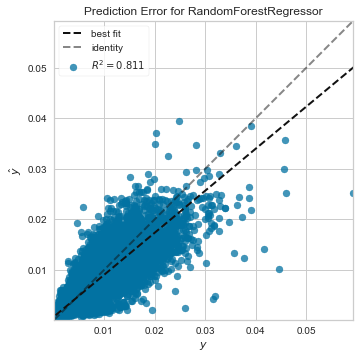

In [55] used 0.0742 MiB RAM in 5.16s, peaked 0.00 MiB above current, total RAM usage 6268.81 MiB


In [55]:
try:
    if X_test.shape[0] > 0:
        from yellowbrick.regressor import PredictionError
        visualizer = PredictionError(est)
        visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data
        ax_subplot = visualizer.show()        
except ModuleNotFoundError:
    print('no yellowbrick')

In [56]:
if 'feature_importances_' in dir(est):
    feature_col = 'feature_importances_'
if 'coef_' in dir(est):
    feature_col = 'coef_'
df_features = pd.DataFrame(zip(getattr(est, feature_col), feature_cols), columns=['importance', 'feature']).set_index('importance')
df_features.sort_index(ascending=False)

,feature
importance,
0.679748,log_return1_linear_weight
0.145496,log_return1
0.021974,log_return2
0.015845,size
0.012172,bid_size1_mean
0.011502,ask_size1_mean
0.010955,bid_size2_var
0.010810,ask_size2_var
0.010767,bid_size1_var


In [56] used 0.1016 MiB RAM in 0.29s, peaked 0.00 MiB above current, total RAM usage 6268.91 MiB


# Make predictions

In [57]:
len(stock_ids) # expecting 112

112

In [57] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 6268.91 MiB


In [58]:
if USE_TEST_LOCAL_6_ITEMS: # True if debugging
    # book train as a substitute
    df_test_all = pd.read_csv(os.path.join(ROOT, 'test_local.csv'))
    df_test_all = df_test_all.rename(columns={'target': 'train_target'})
    TEST_FOLDER = 'book_test_local.parquet'
    assert ENV_HOME == True
else:
    df_test_all = pd.read_csv(TEST_CSV)
    if df_test_all.shape[0] == 3: # kaggle test data
        df_test_all = df_test_all[:1] # cut out 2 rows so predictions work    
    TEST_FOLDER = 'book_test.parquet'
print(ROOT, TEST_FOLDER)
df_test_all = df_test_all.set_index(['stock_id', 'time_id'])

show_details(df_test_all)

/home/ian/data/kaggle/optiver_volatility/ book_test_local.parquet
[2c] 22,980x2, 0 nulls, is_view True, is_single_block True, is_consolidated True
In [58] used 0.6172 MiB RAM in 0.14s, peaked 0.00 MiB above current, total RAM usage 6269.53 MiB


In [59]:
test_set_predictions = []
stock_ids_test = get_training_stock_ids(TEST_FOLDER) # all stocks by default

df_test_predictions = pd.DataFrame() # prediction set to build up
for stock_id in tqdm(stock_ids_test):
    df_test_all_X = df_test_all.query('stock_id==@stock_id').copy()
    test_merged = load_data_build_features(stock_id, ROOT, TEST_FOLDER, cols, df_test_all)
    test_set_predictions_X = est.predict(test_merged.reset_index()[list(features) + ['stock_id']])
    df_test_all_X['target'] = test_set_predictions_X
    df_test_predictions = pd.concat((df_test_predictions, df_test_all_X))
    
assert df_test_all.shape[0] == df_test_predictions.shape[0], "Expecting all rows to be predicted"

  0%|                                                                                                                                                                                                                   | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_721316/1151768668.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if weights == 'linear':
 17%|█████████████████████████████████▊                                                                                                                                                                         | 1/6 [00:12<01:02, 12.51s/it]/tmp/ipykernel_721316/1151768668.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if weights == 'linear':
 33%|███████████████████████████████████████████████████████████████████▋                                                                     

In [59] used 40.0391 MiB RAM in 73.87s, peaked 434.25 MiB above current, total RAM usage 6309.57 MiB


In [60]:
print(f"Writing {df_test_predictions.shape[0]} rows to submission.csv on {datetime.datetime.utcnow()}")
df_test_predictions.reset_index()[['row_id', 'target']].to_csv('submission.csv', index=False)
show_details(df_test_predictions)
print(f'Notebook took {datetime.datetime.utcnow()-t1_notebook_start} to run')

Writing 22980 rows to submission.csv on 2021-08-04 18:49:14.940272
[2c] 22,980x3, 0 nulls, is_view True, is_single_block True, is_consolidated True
Notebook took 0:55:46.108152 to run
In [60] used -0.1836 MiB RAM in 0.19s, peaked 0.18 MiB above current, total RAM usage 6309.38 MiB


In [61]:
if not ENV_HOME:
    assert USE_ALL_STOCK_IDS, "If we're on Kaggle but not using all stock_ids, we're not ready to submit, so fail here to remind me to change USSE_ALL_STOCK_IDS!"

In [61] used 0.1641 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 6309.55 MiB


In [62]:
if False:
    print(f'Iterating over {len(stock_ids)} stocks:')
    all_train_merged = []
    for stock_id in tqdm(stock_ids):
        assert isinstance(stock_id, int)
        df_book_train_stock_X = pd.read_parquet(
            os.path.join(ROOT, f"book_train.parquet/stock_id={stock_id}")
        )
        df_book_train_stock_X["stock_id"] = stock_id
        df_book_train_stock_X = df_book_train_stock_X.set_index(['stock_id', 'time_id'])
        assert df_book_train_stock_X.shape[0] > rows_for_stock_id_0, (df_book_train_stock_X.shape[0], rows_for_stock_id_0)

        cols = ['bid_price1', 'ask_price1', 'bid_price2', 'ask_price2', 'bid_size1', 'ask_size1']
        features_var1 = make_features_stats(df_book_train_stock_X, 'var', cols)
        #print(f"{features_var1.memory_usage().sum() / 1_000_000:0.1f} MB")
        features_mean1 = make_features_stats(df_book_train_stock_X, 'mean', cols)

        # inner join, so we just get the subset
        df_train_stock_X = df_train_all.query('stock_id == @stock_id')
        to_merge = [df_train_stock_X, features_var1, features_mean1]
        row_lengths = [df.shape[0] for df in to_merge]
        assert len(set(row_lengths)) == 1, row_lengths # should all be same length
        train_merged = pd.concat(to_merge, axis=1)
        all_train_merged.append(train_merged)

In [62] used 0.0000 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 6309.55 MiB


In [63]:
if False:
    #for stock_id in tqdm(stock_ids_test):
    if False:
        parquet_filename = os.path.join(ROOT, f'{TEST_FOLDER}/stock_id={stock_id}')
        #print(f"reading {parquet_filename}")
        df_book_test_stock_X = pd.read_parquet(parquet_filename)
        df_book_test_stock_X['stock_id'] = stock_id
        features_var1_test = make_features_stats(df_book_test_stock_X, 'var', cols)
        features_mean1_test = make_features_stats(df_book_test_stock_X, 'mean', cols)

        df_test_all_X = df_test_all.query('stock_id==@stock_id').copy()
        test_merged = pd.merge(df_test_all_X, features_var1_test, left_index=True, right_index=True)
        test_merged = pd.merge(test_merged, features_mean1_test, left_index=True, right_index=True)
        #test_merged = pd.merge(df_test_all_X, features_var1_test, left_index=True, right_index=True)
        test_set_predictions_X = est.predict(test_merged.reset_index()[list(features) + ['stock_id']])
        df_test_all_X['target'] = test_set_predictions_X
        df_test_predictions = pd.concat((df_test_predictions, df_test_all_X))


In [63] used -0.0195 MiB RAM in 0.11s, peaked 0.02 MiB above current, total RAM usage 6309.53 MiB
